In [21]:
import torch
import torch.nn as nn

import source
from source import propagator

%matplotlib widget
import matplotlib.pyplot as plt

## Подготовка

In [25]:
right_matrix_count_columns: int = 16
right_matrix_count_rows: int = 16
pixel_size: float = 3.6e-6

config = source.Config(right_matrix_count_columns = right_matrix_count_columns,
                       right_matrix_count_rows = right_matrix_count_rows,
                       right_matrix_width = pixel_size * right_matrix_count_columns,
                       right_matrix_height = pixel_size * right_matrix_count_rows,
                       min_height_gap = pixel_size,
                       right_matrix_split_x = 2,
                       right_matrix_split_y = 2,
                       left_matrix_split_x = 2,
                       left_matrix_split_y = 2,
                       result_matrix_split = 2,
                       distance = 0.01
                      )

In [26]:
mul = source.OpticalMul(config)

In [27]:
distributed_mul = source.DataParallel(mul, output_device = 'cpu')

## Пример работы с вещественными матрицами
В случае использования модели в машинном обучении предполагается, что левая матрица - вход слоя, правая - обновляемые веса

In [33]:
mat1 = torch.rand((1, 1, 16, right_matrix_count_rows)) * 100
mat2 = torch.rand((1, 1, right_matrix_count_rows, right_matrix_count_columns)) * 100

In [34]:
res = distributed_mul(mat1, mat2)**2

In [35]:
fr = (mat1 @ mat2)**2

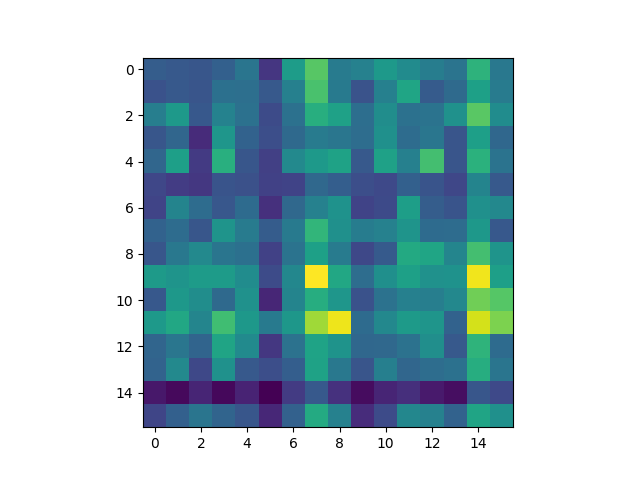

In [36]:
plt.figure()
plt.imshow(res[0, 0])

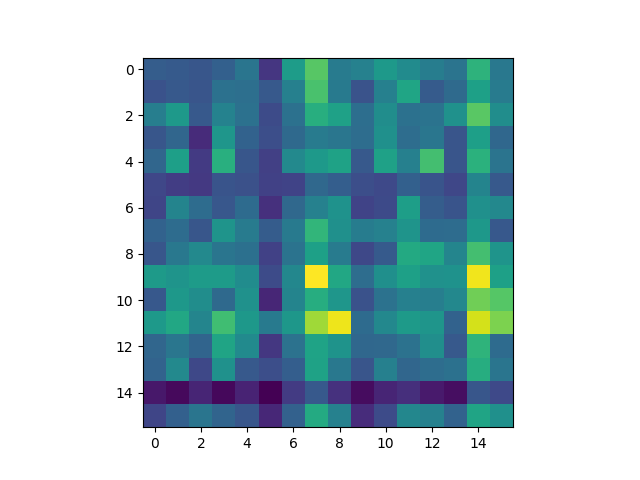

In [37]:
plt.figure()
plt.imshow(fr[0, 0])

In [38]:
CKO = (((fr / fr.mean() - res / res.mean())**2).mean())**0.5 * 100

In [39]:
CKO

tensor(0.0451)

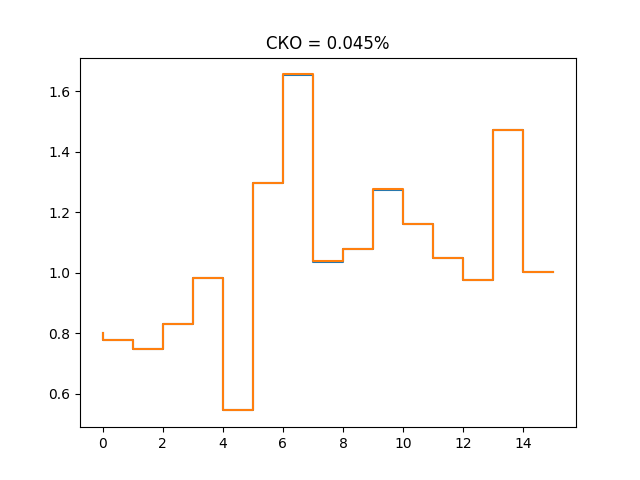

In [40]:
plt.figure()
plt.step(range(fr.size(-1)), fr[0, 0, 0] / fr.mean())
plt.step(range(res.size(-1)), res[0, 0, 0]/ res.mean())
plt.title(f"СКО = {CKO :.3f}%");

## Пример работы с комплексными матрицами

In [41]:
config = source.Config(right_matrix_count_columns = right_matrix_count_columns,
                       right_matrix_count_rows = right_matrix_count_rows,
                       right_matrix_width = pixel_size * right_matrix_count_columns,
                       right_matrix_height = pixel_size * right_matrix_count_rows,
                       min_height_gap = pixel_size,
                       right_matrix_split_x = 2,
                       right_matrix_split_y = 2,
                       left_matrix_split_x = 2,
                       left_matrix_split_y = 2,
                       result_matrix_split = 2,
                       distance = 0.01
                      )

mul = source.OpticalMul(config)

In [42]:
distributed_mul = source.DataParallel(mul, output_device = 'cpu')

In [43]:
mat1 = torch.rand(1, 1, 16, right_matrix_count_rows)
mat2 = torch.exp(1j * torch.rand((1, 1, right_matrix_count_rows, right_matrix_count_columns)))

In [50]:
res = distributed_mul(mat1, mat2)[0, 0]**2
fr = (mat1.cfloat() @ mat2)[0, 0].abs()**2

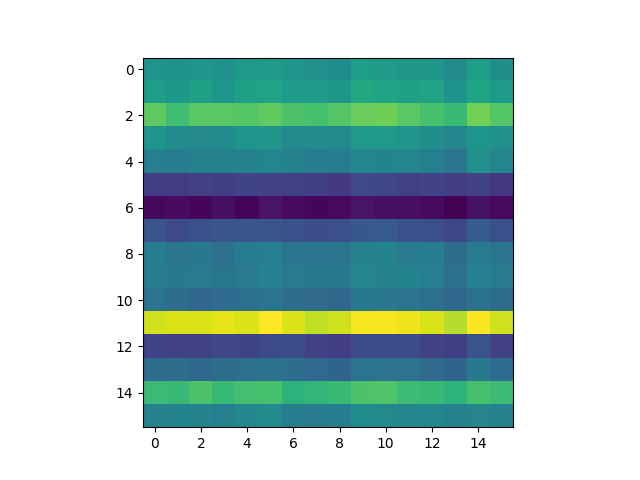

In [51]:
plt.figure()
plt.imshow(res)

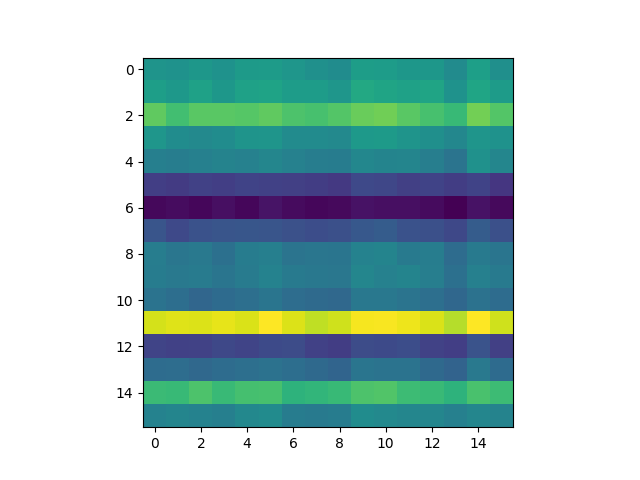

In [52]:
plt.figure()
plt.imshow(fr)

In [53]:
CKO = (((fr / fr.mean() - res / res.mean())**2).mean())**0.5 * 100

In [54]:
CKO

tensor(0.0434)

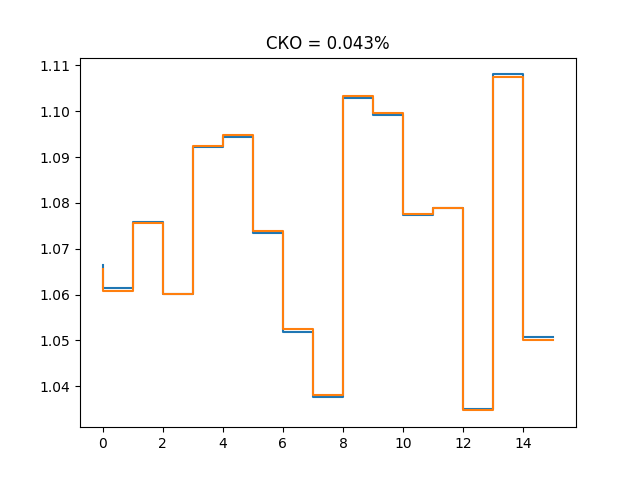

In [55]:
plt.figure()
plt.step(range(fr.size(-1)), fr[0] / fr.mean())
plt.step(range(res.size(-1)), res[0]/ res.mean())
plt.title(f"СКО = {CKO :.3f}%");